# Capítulo 10 · ElasticNet y comparación final de modelos

**Objetivo:** combinar las penalizaciones L1 (Lasso) y L2 (Ridge) mediante **ElasticNet** y construir una **comparación final** entre:

- Modelo lineal clásico (**OLS**)
- **Ridge** (L2)
- **Lasso** (L1)
- **ElasticNet** (L1 + L2)

Usaremos las **mismas variables candidatas** que en los capítulos anteriores y el mismo esquema de partición entrenamiento/prueba.


## 10.1 Datos, variables seleccionadas y partición entrenamiento/prueba

Partimos del dataset *Ames Housing* y aplicamos el mismo criterio automático:

- Alta correlación absoluta con `SalePrice`.  
- Colinealidad moderada entre predictores (|ρ| ≤ 0.85).  


In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score

# Localizar dataset
CANDIDATE_PATHS = [Path('data/ames_housing.csv'), Path('AmesHousing.csv')]
for p in CANDIDATE_PATHS:
    if p.exists():
        DATA_PATH = p
        break
else:
    raise FileNotFoundError('No se encontró data/ames_housing.csv ni AmesHousing.csv')

df = pd.read_csv(DATA_PATH)

target = "SalePrice"

# Numéricas y limpieza de infinitos
num_df = df.select_dtypes(include=[np.number]).replace([np.inf, -np.inf], np.nan)

# Pool de variables según correlación absoluta con SalePrice
corr_abs = num_df.corr(numeric_only=True)[target].dropna().abs().sort_values(ascending=False)
pool = [c for c in corr_abs.index if c != target][:15]

sel = []
for v in pool:
    if not sel:
        sel.append(v)
        continue
    ok = True
    for u in sel:
        r = abs(num_df[[v, u]].dropna().corr().iloc[0, 1])
        if r > 0.85:
            ok = False
            break
    if ok:
        sel.append(v)
    if len(sel) >= 12:
        break

data = num_df[[target] + sel].dropna()
X = data[sel].values
y = data[target].values

feature_names = sel

X.shape, y.shape, feature_names

((2748, 12),
 (2748,),
 ['Overall Qual',
  'Gr Liv Area',
  'Garage Cars',
  'Total Bsmt SF',
  '1st Flr SF',
  'Year Built',
  'Full Bath',
  'Year Remod/Add',
  'Garage Yr Blt',
  'Mas Vnr Area',
  'TotRms AbvGrd',
  'Fireplaces'])

Mostramos las variables candidatas ordenadas por correlación absoluta con `SalePrice`:

In [2]:
pd.DataFrame({
    "Variable": sel,
    "abs(corr SalePrice)": corr_abs[sel].values
}).round(3)

,Variable,abs(corr SalePrice)
0,Overall Qual,0.799
1,Gr Liv Area,0.707
2,Garage Cars,0.648
3,Total Bsmt SF,0.632
4,1st Flr SF,0.622
5,Year Built,0.558
6,Full Bath,0.546
7,Year Remod/Add,0.533
8,Garage Yr Blt,0.527
9,Mas Vnr Area,0.508


Usamos la misma partición entrenamiento/prueba (70% / 30%):

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_train.shape, X_test.shape

((1923, 12), (825, 12))

## 10.2 Modelo OLS base (referencia)

Ajustamos un modelo de regresión lineal clásico sin regularización (OLS) para usarlo como base de comparación.


In [4]:
ols = LinearRegression()
ols.fit(X_train, y_train)

y_train_pred_ols = ols.predict(X_train)
y_test_pred_ols = ols.predict(X_test)

rmse_train_ols = np.sqrt(mean_squared_error(y_train, y_train_pred_ols))
rmse_test_ols = np.sqrt(mean_squared_error(y_test, y_test_pred_ols))
r2_train_ols = r2_score(y_train, y_train_pred_ols)
r2_test_ols = r2_score(y_test, y_test_pred_ols)

coef_ols = pd.Series(ols.coef_, index=feature_names)

rmse_train_ols, rmse_test_ols, r2_train_ols, r2_test_ols

(np.float64(36199.70732578323),
 np.float64(34302.280689270854),
 0.7928837406644176,
 0.813620818779851)

Coeficientes OLS para las variables seleccionadas:

In [5]:
coef_ols.round(4)

Overall Qual      19413.9215
Gr Liv Area          50.3840
Garage Cars       14928.9791
Total Bsmt SF        20.7325
1st Flr SF           11.2901
Year Built          151.5614
Full Bath         -6644.2333
Year Remod/Add      359.5447
Garage Yr Blt        70.3224
Mas Vnr Area         32.6375
TotRms AbvGrd     -1917.0279
Fireplaces         8588.6569
dtype: float64

## 10.3 Estandarización de predictores

Para las técnicas de regularización (Ridge, Lasso y ElasticNet) es importante que las variables estén en la misma escala, por lo que estandarizamos:

- Media 0  
- Desviación estándar 1  


In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled[:3]

array([[-0.8483711 , -1.1762113 , -1.3322942 , -0.3348402 , -0.6442113 ,
        -0.07847238, -1.02952515,  0.83262602, -0.29724965, -0.40179443,
        -0.93524871, -0.95938847],
       [-0.11973438, -0.92537101,  0.22231851, -0.04715108, -0.32322843,
        -0.24825456,  0.7768406 , -0.96063509, -0.49561551, -0.04149524,
        -0.93524871, -0.95938847],
       [-0.8483711 , -1.20560664, -1.3322942 , -1.30803857, -0.68182648,
        -2.11585844, -1.02952515, -1.68763284, -1.88417655, -0.57648495,
        -0.93524871, -0.95938847]])

## 10.4 Recordatorio: Ridge y Lasso

Reajustamos Ridge y Lasso (como en el capítulo anterior) para tener todos los modelos en el mismo notebook y poder compararlos con ElasticNet.


In [7]:
# Ridge
alphas_ridge = np.logspace(-3, 3, 30)
ridge_cv = RidgeCV(alphas=alphas_ridge)
ridge_cv.fit(X_train_scaled, y_train)

alpha_ridge_best = ridge_cv.alpha_

y_train_pred_ridge = ridge_cv.predict(X_train_scaled)
y_test_pred_ridge = ridge_cv.predict(X_test_scaled)

rmse_train_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
rmse_test_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))
r2_train_ridge = r2_score(y_train, y_train_pred_ridge)
r2_test_ridge = r2_score(y_test, y_test_pred_ridge)

coef_ridge = pd.Series(ridge_cv.coef_, index=feature_names)

alpha_ridge_best, rmse_test_ridge, r2_test_ridge

(np.float64(92.36708571873865),
 np.float64(34276.402249856335),
 0.8139019302910604)

In [8]:
# Lasso
alphas_lasso = np.logspace(-4, 1, 40)
lasso_cv = LassoCV(alphas=alphas_lasso, cv=5, random_state=42, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)

alpha_lasso_best = lasso_cv.alpha_

y_train_pred_lasso = lasso_cv.predict(X_train_scaled)
y_test_pred_lasso = lasso_cv.predict(X_test_scaled)

rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))
rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_test_pred_lasso))
r2_train_lasso = r2_score(y_train, y_train_pred_lasso)
r2_test_lasso = r2_score(y_test, y_test_pred_lasso)

coef_lasso = pd.Series(lasso_cv.coef_, index=feature_names)

alpha_lasso_best, rmse_test_lasso, r2_test_lasso

(np.float64(10.0), np.float64(34301.49138375624), 0.8136293959601474)

## 10.5 ElasticNet (L1 + L2)

ElasticNet combina las penalizaciones L1 y L2 mediante los parámetros:

- $\alpha$: intensidad global de la penalización.  
- `l1_ratio` $\in [0, 1]$: peso relativo de L1 vs L2  
  - `l1_ratio = 1` → Lasso  
  - `l1_ratio = 0` → Ridge  

Usamos `ElasticNetCV` para seleccionar automáticamente $\alpha$ y `l1_ratio` por validación cruzada.


In [9]:
l1_grid = [0.1, 0.3, 0.5, 0.7, 0.9]
alphas_enet = np.logspace(-4, 1, 40)

enet_cv = ElasticNetCV(
    l1_ratio=l1_grid,
    alphas=alphas_enet,
    cv=5,
    random_state=42,
    max_iter=10000
)
enet_cv.fit(X_train_scaled, y_train)

alpha_enet_best = enet_cv.alpha_
l1ratio_enet_best = enet_cv.l1_ratio_

alpha_enet_best, l1ratio_enet_best

(np.float64(0.11937766417144358), np.float64(0.7))

Evaluamos el desempeño de ElasticNet:

In [10]:
y_train_pred_enet = enet_cv.predict(X_train_scaled)
y_test_pred_enet = enet_cv.predict(X_test_scaled)

rmse_train_enet = np.sqrt(mean_squared_error(y_train, y_train_pred_enet))
rmse_test_enet = np.sqrt(mean_squared_error(y_test, y_test_pred_enet))
r2_train_enet = r2_score(y_train, y_train_pred_enet)
r2_test_enet = r2_score(y_test, y_test_pred_enet)

rmse_train_enet, rmse_test_enet, r2_train_enet, r2_test_enet

(np.float64(36249.78184760485),
 np.float64(34266.542053707475),
 0.7923103426117015,
 0.8140089835067096)

Coeficientes ElasticNet (escala estandarizada):

In [11]:
coef_enet = pd.Series(enet_cv.coef_, index=feature_names)
coef_enet.round(4)

Overall Qual      25464.3468
Gr Liv Area       22438.3519
Garage Cars        9409.1082
Total Bsmt SF      9122.1792
1st Flr SF         5251.1961
Year Built         4238.9828
Full Bath         -2437.8669
Year Remod/Add     7499.8755
Garage Yr Blt      2248.5929
Mas Vnr Area       6322.5864
TotRms AbvGrd      -998.6363
Fireplaces         6077.5435
dtype: float64

## 10.6 Comparación de coeficientes entre todos los modelos

Construimos una tabla con los coeficientes estimados por cada modelo:

- OLS  
- Ridge  
- Lasso  
- ElasticNet  


In [12]:
coef_comp = pd.DataFrame({
    "OLS": coef_ols,
    "Ridge": coef_ridge,
    "Lasso": coef_lasso,
    "ElasticNet": coef_enet,
})

coef_comp.round(4)

,OLS,Ridge,Lasso,ElasticNet
Overall Qual,19413.9215,25074.4748,26649.1629,25464.3468
Gr Liv Area,50.3840,21610.0694,25643.7181,22438.3519
Garage Cars,14928.9791,9355.1281,9593.8912,9409.1082
Total Bsmt SF,20.7325,9103.1686,9226.5711,9122.1792
1st Flr SF,11.2901,5437.8894,4503.5636,5251.1961
Year Built,151.5614,4209.6329,4455.7497,4238.9828
Full Bath,-6644.2333,-2093.6113,-3638.4054,-2437.8669
Year Remod/Add,359.5447,7513.6876,7410.5281,7499.8755
Garage Yr Blt,70.3224,2374.3883,1765.9696,2248.5929
Mas Vnr Area,32.6375,6409.1573,5977.2546,6322.5864


Gráfico de barras comparando coeficientes por variable:

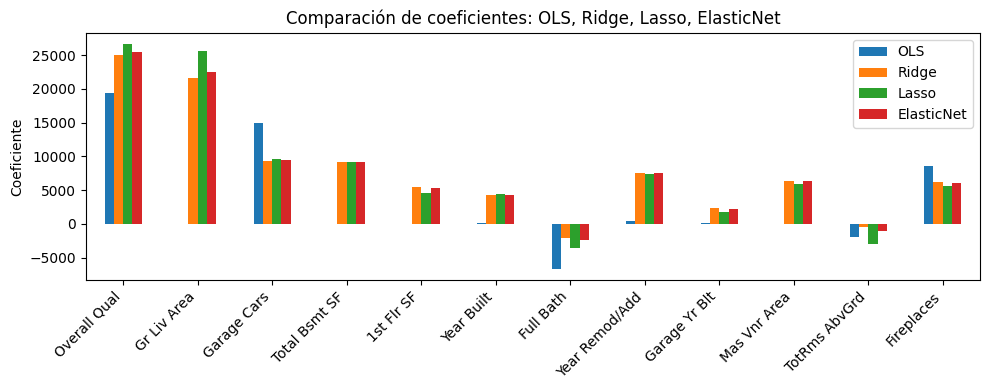

In [13]:
ax = coef_comp.plot(kind="bar", figsize=(10,4))
ax.set_ylabel("Coeficiente")
ax.set_title("Comparación de coeficientes: OLS, Ridge, Lasso, ElasticNet")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 10.7 Comparación de desempeño predictivo

Resumimos **RMSE** y **$R^2$** en entrenamiento y prueba para los cuatro modelos.


In [14]:
metrics_table = pd.DataFrame({
    "RMSE_train": [rmse_train_ols, rmse_train_ridge, rmse_train_lasso, rmse_train_enet],
    "RMSE_test":  [rmse_test_ols,  rmse_test_ridge,  rmse_test_lasso,  rmse_test_enet],
    "R2_train":   [r2_train_ols,   r2_train_ridge,   r2_train_lasso,   r2_train_enet],
    "R2_test":    [r2_test_ols,    r2_test_ridge,    r2_test_lasso,    r2_test_enet],
}, index=["OLS", "Ridge", "Lasso", "ElasticNet"]).round(4)

metrics_table

,RMSE_train,RMSE_test,R2_train,R2_test
OLS,36199.7073,34302.2807,0.7929,0.8136
Ridge,36281.2553,34276.4022,0.7919,0.8139
Lasso,36199.7321,34301.4914,0.7929,0.8136
ElasticNet,36249.7818,34266.5421,0.7923,0.8140


Gráfico comparando RMSE en el conjunto de prueba:

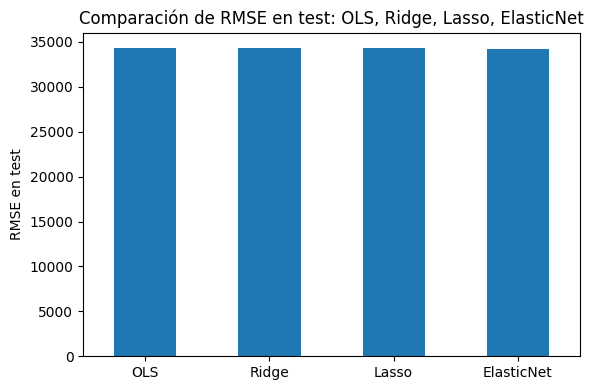

In [15]:
ax = metrics_table["RMSE_test"].plot(kind="bar", figsize=(6,4))
ax.set_ylabel("RMSE en test")
ax.set_title("Comparación de RMSE en test: OLS, Ridge, Lasso, ElasticNet")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Y también comparamos el $R^2$ en prueba:

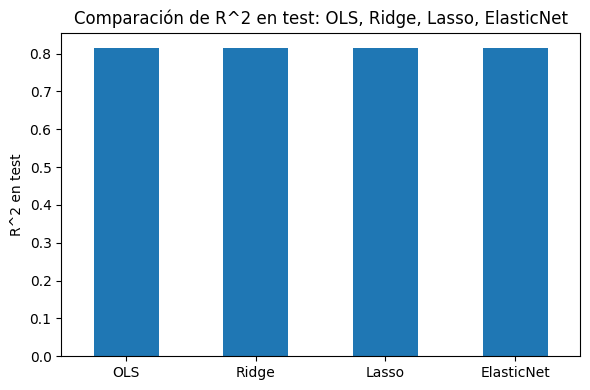

In [16]:
ax = metrics_table["R2_test"].plot(kind="bar", figsize=(6,4))
ax.set_ylabel("R^2 en test")
ax.set_title("Comparación de R^2 en test: OLS, Ridge, Lasso, ElasticNet")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 10.8 Complejidad efectiva: número de coeficientes distintos de cero

Contamos cuántos coeficientes quedan diferentes de 0 en cada método (particularmente relevante para Lasso y ElasticNet).

In [17]:
def nonzero_count(series, tol=1e-8):
    return np.sum(np.abs(series.values) > tol)

nz_ols  = nonzero_count(coef_ols)
nz_ridge = nonzero_count(coef_ridge)
nz_lasso = nonzero_count(coef_lasso)
nz_enet  = nonzero_count(coef_enet)

nz_table = pd.DataFrame({
    "n_coef_no_cero": [nz_ols, nz_ridge, nz_lasso, nz_enet]
}, index=["OLS", "Ridge", "Lasso", "ElasticNet"])

nz_table

,n_coef_no_cero
OLS,12
Ridge,12
Lasso,12
ElasticNet,12


Gráfico del número de coeficientes no nulos por modelo:

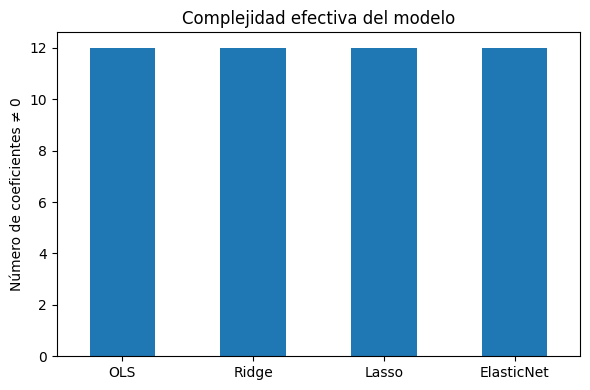

In [18]:
ax = nz_table["n_coef_no_cero"].plot(kind="bar", figsize=(6,4))
ax.set_ylabel("Número de coeficientes ≠ 0")
ax.set_title("Complejidad efectiva del modelo")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 10.9 Observado vs predicho para el modelo elegido

Podemos elegir como **modelo final** el que muestre mejor compromiso entre:

- Bajo RMSE en prueba.  
- Alto $R^2$ en prueba.  
- Complejidad razonable (no demasiados coeficientes activos).  

A modo de ejemplo, graficamos observados vs predichos para **ElasticNet**.


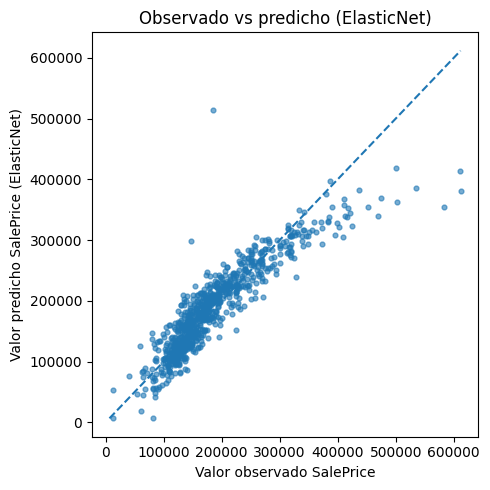

In [19]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_test_pred_enet, s=12, alpha=0.6)
min_val = min(y_test.min(), y_test_pred_enet.min())
max_val = max(y_test.max(), y_test_pred_enet.max())
plt.plot([min_val, max_val], [min_val, max_val], "--")
plt.xlabel("Valor observado SalePrice")
plt.ylabel("Valor predicho SalePrice (ElasticNet)")
plt.title("Observado vs predicho (ElasticNet)")
plt.tight_layout()
plt.show()

## 10.10 Key takeaways

- **ElasticNet** combina las ventajas de Ridge y Lasso:
  - Control de multicolinealidad vía penalización L2.
  - Selección de variables vía penalización L1.
- La comparación conjunta de:
  - Coeficientes,
  - RMSE / $R^2$ en prueba,
  - Número de coeficientes no nulos,
  permite elegir un modelo final adecuado al compromiso **sesgo–varianza**.
- En la práctica, es común:
  - Usar OLS como modelo de referencia interpretativo.
  - Compararlo con modelos regularizados (Ridge/Lasso/ElasticNet) para mejorar generalización en datos nuevos.

Con este capítulo se cierra el ciclo de modelamiento lineal para el dataset *Ames Housing*, dejando una base sólida para extender a modelos no lineales o técnicas más avanzadas.
